<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Benchmark-pqlite" data-toc-modified-id="Benchmark-pqlite-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Benchmark pqlite</a></span><ul class="toc-item"><li><span><a href="#Time" data-toc-modified-id="Time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Time</a></span></li><li><span><a href="#Quality" data-toc-modified-id="Quality-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Quality</a></span><ul class="toc-item"><li><span><a href="#Plotting-pq-neighbors-vs-true-neighbors" data-toc-modified-id="Plotting-pq-neighbors-vs-true-neighbors-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Plotting <code>pq neighbors</code> vs <code>true neighbors</code></a></span></li></ul></li><li><span><a href="#precision,-recall,-query_time-vs-n_subvectors-&amp;--n_cells" data-toc-modified-id="precision,-recall,-query_time-vs-n_subvectors-&amp;--n_cells-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><code>precision, recall, query_time</code> vs <code>n_subvectors</code> &amp;  <code>n_cells</code></a></span></li></ul></li></ul></div>

## Benchmark pqlite

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!rm -rf data/

In [4]:
import pqlite
pqlite.__path__
import time

import jina
from docarray.math.distance import cdist

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /Users/fengwang/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/feature_extraction/image.py:172)


In [6]:
import random
import numpy as np
from pqlite import PQLite

#N = 100_000 # number of data points
Nt = 12_500 
Nq = 1
D = 128 # dimentionality / number of features
top_k = 100
n_cells = 18
n_subvectors = 128

# 2,000 128-dim vectors for training
np.random.seed(123)
Xtr, Xte = train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), test_size=20)
#Xt = np.random.random((Nt, D)).astype(np.float32)  

# the column schema: (name:str, dtype:type, create_index: bool)
pq = PQLite(dim=D, 
            metric='euclidean',
            n_cells=n_cells,
            n_subvectors=n_subvectors, 
            columns=[('x',float)])

pq.pq_codec.fit(Xtr)

2021-12-21 01:40:25.194 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=18)
2021-12-21 01:40:25.194 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=128)


In [7]:
from jina import Document, DocumentArray

da = DocumentArray([Document(id=f'{i}', embedding=Xtr[i]) for i in range(len(Xtr))])
pq.train(Xtr)
pq.index(da)

2021-12-21 01:41:22.824 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=18) with 12480 data...
2021-12-21 01:41:23.203 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=128) with 12480 data...
2021-12-21 01:42:20.537 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:42:20.538 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/bb79b2424c66ca6ba5a8c46814345738
2021-12-21 01:42:21.649 | DEBUG    | pqlite.container:insert:225 - => 12480 new docs added


In [8]:
Nq = 1
query_da = DocumentArray([Document(embedding=Xte[10])])

# without filtering
#pq.search(query_da, limit=5)

In [9]:
pq.search(query_da,  limit=top_k)

### Time

In [18]:
%timeit pq._search_numpy(Xte[[10]],  limit=top_k)

41.7 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit pq.search(query_da,  limit=top_k)

45.5 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit res = cdist(Xte[[10]], Xtr, metric='euclidean')

940 µs ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Quality

Manually observing slices of a high dimensional space it seems that the
retrieved items from pqlite are nearby the query and the best values from the exact and exhaustive distance computations.

In [21]:
def _precision(predicted, relevant, eval_at):
    """
    fraction of retrieved documents that are relevant to the query
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))

    return n_predicted_and_relevant / len(predicted)

def _recall(predicted, relevant, eval_at):
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))
    return n_predicted_and_relevant/ len(relevant)


In [22]:
query = Xte[[11]]  
true_distances = cdist(query, Xtr, metric='euclidean').flatten()

true_ids = np.argsort(true_distances)[0:top_k]
true_dists = true_distances[true_ids]

In [23]:
true_ids.sort()
true_ids

array([    0,   192,   300,   371,   545,   677,   767,   813,   933,
        1000,  1131,  1219,  1308,  1389,  1590,  1615,  1686,  1713,
        1740,  1802,  1943,  2372,  2447,  2618,  2719,  2921,  3010,
        3258,  3337,  3418,  3926,  3967,  4140,  4376,  4612,  4625,
        4661,  5243,  5433,  5491,  5534,  5619,  5657,  5693,  5699,
        5875,  6016,  6413,  6440,  6511,  6624,  6772,  6825,  7103,
        7125,  7155,  7948,  8025,  8052,  8098,  8251,  8327,  8366,
        8551,  8572,  8931,  9087,  9094,  9239,  9356,  9739,  9867,
        9877,  9952,  9978,  9987, 10077, 10174, 10187, 10214, 10277,
       10457, 10488, 10982, 11059, 11077, 11083, 11115, 11172, 11280,
       11379, 11382, 11445, 11641, 11911, 12001, 12194, 12212, 12234,
       12342])

In [25]:
pq_dists, pq_ids = pq._search_numpy(query,  limit=top_k)
pq_ids = pq_ids[0]

In [26]:
pq_ids

array([    0,   767,  4612,  1686,  7103, 11280, 10457, 12212,  2372,
        9356, 11911,  1943,  5875,  9952,  2447, 10982, 11077,  6413,
       10277,  1000, 11641, 12001, 11115,  8551,  5534,  9087,  4661,
        1219,  3258,  6016,  1389,  7948,  5699,  6440,  9239,  5433,
       11379,  2921,  7155, 11445,  8052,  5243,   371,  4140,  8251,
        1590, 12234,   545,  3926,  7125,  5693,  9739,  6772,  1308,
        8931,  8572,  1131, 11172, 12342,  6825,  9094, 10488,  2618,
       10187,  5619,  9867,   933,  4376, 11083,   813,  1802,  3418,
       12194, 10174,  1740,   300,  8025,  3337,  1713, 10077,   677,
        9987, 10214,  4625,  6624,  9978,  9877,  8366,  5657,  8098,
        8327,  2719,  9980,   192,  3010, 11059,   608,  6511,  3967,
       11382])

In [27]:
print(_precision(true_ids, pq_ids, top_k))
print(_recall(true_ids, pq_ids, top_k))

0.98
0.98


#### Plotting `pq neighbors` vs `true neighbors`

Here we should see orange and black dots close in the feature space (does not seem to work as expected).

In [28]:
import matplotlib.pyplot as plt

def paint_slice(Xtr, query, pq_ids, feat1, feat2):
    plt.scatter(Xtr[:,feat1], Xtr[:,feat2], color='blue', alpha=0.2)

    for pq_id in pq_ids:
        plt.scatter(Xtr[pq_id, feat1], Xtr[pq_id, feat2], color='black')

    for true_id in true_ids:
        plt.scatter(Xtr[true_id, feat1], Xtr[true_id, feat2], color='orange')

    plt.scatter(query[:, feat1], query[:, feat2], color='red')
    

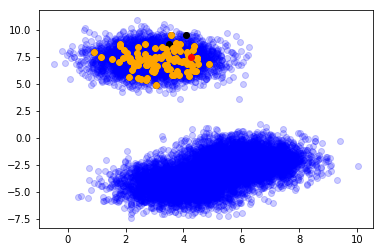

In [29]:
feat1, feat2 = 0, 1
paint_slice(Xtr, query, pq_ids, feat1, feat2)

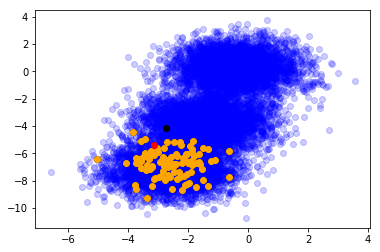

In [30]:
feat1, feat2 = 8, 100
paint_slice(Xtr, query, pq_ids, feat1, feat2)

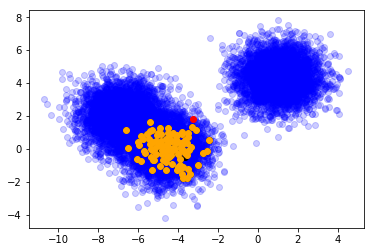

In [31]:
feat1, feat2 = 3,4
paint_slice(Xtr, query, pq_ids, feat1, feat2)


###  `precision, recall, query_time` vs `n_subvectors` &  `n_cells` 

In [34]:
import time
import numpy as np
from pqlite import PQLite

from docarray.math.distance import cdist
from docarray.math.helper import top_k as _top_k
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def _precision(predicted, relevant, eval_at):
    """
    fraction of retrieved documents that are relevant to the query
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))

    return n_predicted_and_relevant / len(predicted)

def _recall(predicted, relevant, eval_at):
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))
    return n_predicted_and_relevant/ len(relevant)

def evaluate(predicts, relevants, eval_at):
    recall = 0
    precision = 0
    for _predict, _relevant in zip(predicts, relevants):
        _predict = np.array([int(x) for x in _predict])
        recall += _recall(_predict, _relevant, top_k)
        precision += _precision(_predict, _relevant, top_k)

    return recall / len(predicts), precision / len(predicts)


#N = 100_000 # number of data points
Nt = 10_000
Nq = 1
D = 128 # dimentionality / number of features
top_k = 10
n_cells = 64
n_subvectors = 64
n_queries = 1000

# 2,000 128-dim vectors for training
np.random.seed(123)
Xtr, Xte = train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), test_size=20)
print(f'Xtr: {Xtr.shape} vs Xte: {Xte.shape}')

precision_per_query = []
recall_per_query = []
results = []

for n_cells in [8, 16, 32, 64, 128]:
    for n_subvectors in [32, 64, 128]:
        !rm -rf data/
        pq = PQLite(dim=D,
                    metric='euclidean',
                    n_cells=n_cells,
                    n_subvectors=n_subvectors)
        
        t0 = time.time()
        pq.train(Xtr[:20480])
        train_time = abs(time.time() - t0)

        t0 = time.time()
        
        Xtr_da = DocumentArray([Document(id=f'{i}', embedding=Xtr[i]) for i in range(len(Xtr))])
        pq.index(Xtr_da, ids=list(range(len(Xtr))))
        index_time = abs(t0 - time.time())

        dists = cdist(Xte, Xtr, metric='euclidean')
        true_dists, true_ids = _top_k(dists, top_k, descending=False)
        
        t0 = time.time()
        pq_dists, pq_ids = pq._search_numpy(Xte, limit=top_k)
        query_time = abs(t0 - time.time())
        recall, precision = evaluate(pq_ids, true_ids, top_k)

        results_dict = {'precision': precision,
                        'recall': recall,
                        'train_time': train_time,
                        'index_time': index_time,
                        'query_time': query_time,
                        'indexer_hyperparams': {'n_cells': n_cells,
                                                'n_subvectors': n_subvectors}
                        }
        print(results_dict)

        results.append(results_dict)

Xtr: (9980, 128) vs Xte: (20, 128)


2021-12-21 01:47:49.038 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=8)
2021-12-21 01:47:49.040 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=32)
2021-12-21 01:47:49.114 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=8) with 9980 data...
2021-12-21 01:47:49.339 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-21 01:48:07.227 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:48:07.227 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/d1304f5ee4600f004f64117d6ce12ebb
2021-12-21 01:48:08.049 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.45500000000000007, 'recall': 0.45500000000000007, 'train_time': 18.115447759628296, 'index_time': 0.8195991516113281, 'query_time': 0.1945500373840332, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 32}}


2021-12-21 01:48:08.430 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=8)
2021-12-21 01:48:08.432 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=64)
2021-12-21 01:48:08.506 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=8) with 9980 data...
2021-12-21 01:48:08.733 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-21 01:48:39.203 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:48:39.204 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/626305e7606537598688ad160806d69f
2021-12-21 01:48:40.115 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.7550000000000001, 'recall': 0.7550000000000001, 'train_time': 30.700277090072632, 'index_time': 0.9096710681915283, 'query_time': 0.2364051342010498, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 64}}


2021-12-21 01:48:40.538 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=8)
2021-12-21 01:48:40.540 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=128)
2021-12-21 01:48:40.608 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=8) with 9980 data...
2021-12-21 01:48:40.848 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-21 01:49:27.669 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:49:27.669 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/f33efae3f283d85b6afef29d4305b0f6
2021-12-21 01:49:28.731 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.9400000000000001, 'recall': 0.9400000000000001, 'train_time': 47.064188957214355, 'index_time': 1.0591418743133545, 'query_time': 0.3858819007873535, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 128}}


2021-12-21 01:49:29.306 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=16)
2021-12-21 01:49:29.308 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=32)
2021-12-21 01:49:29.382 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=16) with 9980 data...
2021-12-21 01:49:29.684 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-21 01:49:47.876 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:49:47.877 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/45f59be7052d7061f734b2b55ce6df0e
2021-12-21 01:49:48.652 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.425, 'recall': 0.425, 'train_time': 18.49602508544922, 'index_time': 0.7737338542938232, 'query_time': 0.3825209140777588, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 32}}


2021-12-21 01:49:49.254 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=16)
2021-12-21 01:49:49.255 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=64)
2021-12-21 01:49:49.374 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=16) with 9980 data...
2021-12-21 01:49:49.730 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-21 01:50:19.748 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:50:19.749 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/cd85824bf658d77a3ce90a7a42a14daf
2021-12-21 01:50:20.675 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.8, 'recall': 0.8, 'train_time': 30.376378059387207, 'index_time': 0.925072193145752, 'query_time': 0.4677870273590088, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 64}}


2021-12-21 01:50:21.408 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=16)
2021-12-21 01:50:21.409 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=128)
2021-12-21 01:50:21.578 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=16) with 9980 data...
2021-12-21 01:50:23.163 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-21 01:51:09.555 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:51:09.556 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/24f8df04c973b4a2e6733b8f79981087
2021-12-21 01:51:10.748 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.9550000000000001, 'recall': 0.9550000000000001, 'train_time': 47.97972369194031, 'index_time': 1.1907119750976562, 'query_time': 0.7938659191131592, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 128}}


2021-12-21 01:51:11.770 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=32)
2021-12-21 01:51:11.771 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=32)
2021-12-21 01:51:11.902 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=32) with 9980 data...
2021-12-21 01:51:12.465 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-21 01:51:30.632 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:51:30.632 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/6e6169129ace0166eaa443eb03643189
2021-12-21 01:51:31.459 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.45999999999999996, 'recall': 0.45999999999999996, 'train_time': 18.731168746948242, 'index_time': 0.8259668350219727, 'query_time': 0.7513010501861572, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 32}}


2021-12-21 01:51:32.510 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=32)
2021-12-21 01:51:32.512 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=64)
2021-12-21 01:51:32.726 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=32) with 9980 data...
2021-12-21 01:51:33.120 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-21 01:52:02.824 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:52:02.825 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/0805ec37d9c6b2e3541df4c983c6b57d
2021-12-21 01:52:03.751 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.8100000000000002, 'recall': 0.8100000000000002, 'train_time': 30.099796056747437, 'index_time': 0.9259891510009766, 'query_time': 0.9218978881835938, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 64}}


2021-12-21 01:52:04.989 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=32)
2021-12-21 01:52:04.991 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=128)
2021-12-21 01:52:05.221 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=32) with 9980 data...
2021-12-21 01:52:05.604 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-21 01:52:52.639 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:52:52.639 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/d4b5ce5fb6c2ffe0121fa0863a53e26b
2021-12-21 01:52:53.780 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.96, 'recall': 0.96, 'train_time': 47.41976499557495, 'index_time': 1.1397409439086914, 'query_time': 1.5295779705047607, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 128}}


2021-12-21 01:52:55.608 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=64)
2021-12-21 01:52:55.609 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=32)
2021-12-21 01:52:55.859 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=64) with 9980 data...
2021-12-21 01:52:56.683 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-21 01:53:15.444 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:53:15.445 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/6fdff810b2a3450f2c6d199086ad702d
2021-12-21 01:53:16.319 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.4699999999999999, 'recall': 0.4699999999999999, 'train_time': 19.58743977546692, 'index_time': 0.8737471103668213, 'query_time': 1.5891377925872803, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 32}}


2021-12-21 01:53:18.365 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=64)
2021-12-21 01:53:18.366 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=64)
2021-12-21 01:53:18.795 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=64) with 9980 data...
2021-12-21 01:53:19.391 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-21 01:53:50.499 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:53:50.500 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/a868cc5aa102be21a3dd1b6f8b9ec374
2021-12-21 01:53:51.590 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.7950000000000002, 'recall': 0.7950000000000002, 'train_time': 31.707350969314575, 'index_time': 1.088120698928833, 'query_time': 1.8415827751159668, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 64}}


2021-12-21 01:53:53.887 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=64)
2021-12-21 01:53:53.888 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=128)
2021-12-21 01:53:54.338 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=64) with 9980 data...
2021-12-21 01:53:55.082 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-21 01:54:41.891 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:54:41.892 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/53fcfdf043b7f1e1886e2f67d2db315b
2021-12-21 01:54:43.101 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.9350000000000002, 'recall': 0.9350000000000002, 'train_time': 47.55520415306091, 'index_time': 1.2084827423095703, 'query_time': 3.300021171569824, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 128}}


2021-12-21 01:54:46.866 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=128)
2021-12-21 01:54:46.868 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=32)
2021-12-21 01:54:47.415 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=128) with 9980 data...
2021-12-21 01:54:48.510 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-21 01:55:06.701 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:55:06.702 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/d9e21e6fe97193567a60d042917f23e0
2021-12-21 01:55:07.586 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.5399999999999999, 'recall': 0.5399999999999999, 'train_time': 19.288440942764282, 'index_time': 0.8831899166107178, 'query_time': 2.9560129642486572, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 32}}


2021-12-21 01:55:11.304 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=128)
2021-12-21 01:55:11.306 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=64)
2021-12-21 01:55:12.169 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=128) with 9980 data...
2021-12-21 01:55:12.925 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-21 01:55:42.921 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:55:42.922 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/8118e7af93ba02938d166bb2a557aa4d
2021-12-21 01:55:44.107 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.7950000000000002, 'recall': 0.7950000000000002, 'train_time': 30.754541158676147, 'index_time': 1.184305191040039, 'query_time': 3.7074859142303467, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 64}}


2021-12-21 01:55:48.594 | INFO     | pqlite.index:__init__:90 - Initialize VQ codec (K=128)
2021-12-21 01:55:48.595 | INFO     | pqlite.index:__init__:100 - Initialize PQ codec (n_subvectors=128)
2021-12-21 01:55:49.491 | INFO     | pqlite.index:train:143 - Start training VQ codec (K=128) with 9980 data...
2021-12-21 01:55:50.447 | INFO     | pqlite.index:train:149 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-21 01:56:37.062 | INFO     | pqlite.index:train:154 - The pqlite is successfully trained!
2021-12-21 01:56:37.064 | INFO     | pqlite.index:dump_model:354 - Save the trained parameters to data/cfe5f214259b790f13d7fb00c6c39203
2021-12-21 01:56:38.442 | DEBUG    | pqlite.container:insert:225 - => 9980 new docs added


{'precision': 0.95, 'recall': 0.95, 'train_time': 47.57413601875305, 'index_time': 1.376985788345337, 'query_time': 6.02495002746582, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 128}}


In [35]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values('recall', ascending=False)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /Users/fengwang/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/internals/construction.py:587)
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /Users/fengwang/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/internals/construction.py:587)
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /Users/fengwang/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/internals/construction.py:587)
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /Users/fengwang/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/internals/construction.py:587)
Deprecated in NumPy 1.20

,precision,recall,train_time,index_time,query_time,indexer_hyperparams
8,0.960,0.960,47.419765,1.139741,1.529578,"{'n_cells': 32, 'n_subvectors': 128}"
5,0.955,0.955,47.979724,1.190712,0.793866,"{'n_cells': 16, 'n_subvectors': 128}"
14,0.950,0.950,47.574136,1.376986,6.024950,"{'n_cells': 128, 'n_subvectors': 128}"
2,0.940,0.940,47.064189,1.059142,0.385882,"{'n_cells': 8, 'n_subvectors': 128}"
11,0.935,0.935,47.555204,1.208483,3.300021,"{'n_cells': 64, 'n_subvectors': 128}"
7,0.810,0.810,30.099796,0.925989,0.921898,"{'n_cells': 32, 'n_subvectors': 64}"
4,0.800,0.800,30.376378,0.925072,0.467787,"{'n_cells': 16, 'n_subvectors': 64}"
10,0.795,0.795,31.707351,1.088121,1.841583,"{'n_cells': 64, 'n_subvectors': 64}"
13,0.795,0.795,30.754541,1.184305,3.707486,"{'n_cells': 128, 'n_subvectors': 64}"
1,0.755,0.755,30.700277,0.909671,0.236405,"{'n_cells': 8, 'n_subvectors': 64}"
